In [1]:
import psycopg2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from config import DB_CONFIG


In [2]:
conn = psycopg2.connect(**DB_CONFIG)

if conn.closed == 0:
    print("Connected to DB")

all_points_sql = 'SELECT * FROM vessels_points_jan_new LIMIT 1000000'

all_points_gdf =  gpd.GeoDataFrame.from_postgis(all_points_sql, conn, geom_col='geom')

Connected to DB


In [3]:
all_points_gdf['datetime'] = pd.to_datetime(all_points_gdf['timest'],unit='ms')
#all_points_gdf['date'] = pd.to_datetime(all_points_gdf['timest'],unit='ms').dt.date
#all_points_gdf['time'] = pd.to_datetime(all_points_gdf['timest'],unit='ms').dt.time


In [4]:
all_points_gdf = all_points_gdf.sort_values(by=['mmsi','datetime'], ascending=[True,True])
all_points_gdf.head()


,timest,mmsi,heading,turn,speed,course,geom,datetime,date,time
66,1.515681e+12,0,NaN,None,0.0,0.0,POINT (23.60816 37.95578),2018-01-11 14:37:38,2018-01-11,14:37:38
121,1.515681e+12,0,NaN,None,0.0,0.0,POINT (23.60816 37.95578),2018-01-11 14:37:58,2018-01-11,14:37:58
189,1.515681e+12,0,NaN,None,0.0,0.0,POINT (23.60816 37.95578),2018-01-11 14:38:19,2018-01-11,14:38:19
279,1.515682e+12,0,NaN,None,0.0,0.0,POINT (23.60816 37.95578),2018-01-11 14:38:48,2018-01-11,14:38:48
317,1.515682e+12,0,NaN,None,0.0,0.0,POINT (23.60816 37.95578),2018-01-11 14:38:58,2018-01-11,14:38:58


In [5]:
cleansed_gdf = all_points_gdf.drop_duplicates(subset=['mmsi','datetime'])
print('Number of records before removing duplicates: {}'.format(len(all_points_gdf)))
print('Number of records after removing duplicates: {}'.format(len(cleansed_gdf)))
cleansed_gdf.head()

Number of records before removing duplicates: 1000000
Number of records after removing duplicates: 997837


,timest,mmsi,heading,turn,speed,course,geom,datetime,date,time
66,1.515681e+12,0,NaN,None,0.0,0.0,POINT (23.60816 37.95578),2018-01-11 14:37:38,2018-01-11,14:37:38
121,1.515681e+12,0,NaN,None,0.0,0.0,POINT (23.60816 37.95578),2018-01-11 14:37:58,2018-01-11,14:37:58
189,1.515681e+12,0,NaN,None,0.0,0.0,POINT (23.60816 37.95578),2018-01-11 14:38:19,2018-01-11,14:38:19
279,1.515682e+12,0,NaN,None,0.0,0.0,POINT (23.60816 37.95578),2018-01-11 14:38:48,2018-01-11,14:38:48
317,1.515682e+12,0,NaN,None,0.0,0.0,POINT (23.60816 37.95578),2018-01-11 14:38:58,2018-01-11,14:38:58


In [6]:
def haversive_dist(p1,p2):
    #lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = p2.x - p1.x
    dlat = p2.y - p1.y

    a = np.sin(dlat/2.0)**2 + np.cos(p1.y) * np.cos(p2.y) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km
    


In [68]:
def calculate_speed(df):
    """Calculating speed of a vessel for each point"""
    
    df['time_diff'] = df['datetime'].diff().dt.total_seconds()
    first_row = df.iloc[0,:]
    for index, row in df[1:].iterrows():
        second_row = row.copy()
        hav_dist = haversive_dist(first_row.geom,second_row.geom)
        df.loc[index,'distance_from_prev'] = hav_dist
        time_diff = df.loc[index,'time_diff']
        if pd.notna(time_diff) and time_diff != 0:
            speed = hav_dist/time_diff
            df.loc[index,'velocity'] = speed
        first_row = second_row.copy()
    #print('Group finished')
    return df
        
        

In [69]:
cleansed_gdf['velocity'] = np.nan
cleansed_gdf['distance_from_prev'] = np.nan
cleansed_gdf = cleansed_gdf.groupby('mmsi',group_keys=False).apply(lambda group : calculate_speed(group))
cleansed_gdf.dropna(subset=['velocity'],inplace=True)

In [70]:
cleansed_gdf.head()

,timest,mmsi,heading,turn,speed,course,geom,datetime,date,time,velocity,distance_from_prev,diff,time_diff
279,1.515682e+12,0,NaN,None,0.0,0.0,POINT (23.60816 37.95578),2018-01-11 14:38:48,2018-01-11,14:38:48,0.0,0.0,29.0,29.0
317,1.515682e+12,0,NaN,None,0.0,0.0,POINT (23.60816 37.95578),2018-01-11 14:38:58,2018-01-11,14:38:58,0.0,0.0,10.0,10.0
348,1.515682e+12,0,NaN,None,0.0,0.0,POINT (23.60816 37.95578),2018-01-11 14:39:09,2018-01-11,14:39:09,0.0,0.0,11.0,11.0
378,1.515682e+12,0,NaN,None,0.0,0.0,POINT (23.60816 37.95578),2018-01-11 14:39:19,2018-01-11,14:39:19,0.0,0.0,10.0,10.0
488,1.515682e+12,0,NaN,None,0.0,0.0,POINT (23.60816 37.95578),2018-01-11 14:39:58,2018-01-11,14:39:58,0.0,0.0,39.0,39.0


In [71]:
x_axis = []
for i in range(0,51):
    x_axis.append(i*5)

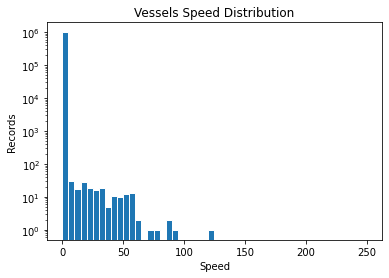

In [72]:
plt.figure('Vessels Speed Distribution')
plt.title('Vessels Speed Distribution')
plt.hist(cleansed_gdf['velocity'], log=True ,bins = x_axis, edgecolor = 'white')
plt.xlabel('Speed')
plt.ylabel('Records')
plt.show()

In [73]:
len(cleansed_gdf['mmsi'].unique())

400

In [74]:
def del_speed_outlier(df):
    outliers = []
    mmsis = df['mmsi'].unique()
    for i,mmsi in enumerate(mmsis):
        df.drop(df[ (df['mmsi'] == mmsi) & (df['velocity'] > 60)].index, inplace=True)
    return df

In [75]:
print('Before deletion of speed outliers: {}'.format(len(cleansed_gdf)))
cleansed_gdf = del_speed_outlier(cleansed_gdf)
print('After deletion of speed outliers: {}'.format(len(tmp)))

Before deletion of speed outliers: 996539
After deletion of speed outliers: 997343


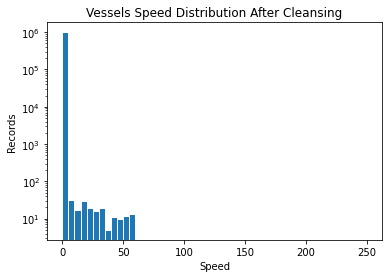

In [76]:
plt.figure('Vessels Speed Distribution After Cleansing')
plt.title('Vessels Speed Distribution After Cleansing')
plt.hist(cleansed_gdf['velocity'], log=True ,bins = x_axis, edgecolor = 'white')
plt.xlabel('Speed')
plt.ylabel('Records')
plt.show()